In [139]:
import torch
import random
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from sklearn.model_selection import train_test_split
import pandas as pd

In [161]:
size = 128

In [140]:
class CatNet(nn.Module):
    def __init__(self, inputsize, outputsize):
        super().__init__()
        self.inputsize = inputsize
        self.outputsize = outputsize
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Flatten(),
            torch.nn.Linear(131072, outputsize),
        ) 
    def forward(self, x):
        return self.model(x)


In [141]:
train_dataset = torch.load("datasets/train.pt")
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=False)
train_dataset = torch.load("datasets/train.pt")
train_dataloader_1 = torch.utils.data.DataLoader(train_dataset)
test_dataset = torch.load("datasets/test.pt")
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)
test_dataset = torch.load("datasets/test.pt")
test_dataloader_1 = torch.utils.data.DataLoader(test_dataset)
result_dataset = torch.load("datasets/predict.pt")
result_dataloader_1 = torch.utils.data.DataLoader(result_dataset)

In [142]:
num_epochs = 1
learning_rate = 0.01
weight_decay = 0.1
model = CatNet(16, 18)
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) 
loss_history = []

for i in range(num_epochs):
    for x_batch, y_batch in train_dataloader:
        predictions = model.forward(x_batch)

        loss = criterion(predictions, y_batch)

        # Backward
        loss.backward()

        # Update weights
        optimizer.step()
        optimizer.zero_grad()

        loss_history.append(loss.item())
    print(f'{i+1}/{num_epochs} current loss: {loss}')   

1/1 current loss: 18.909948348999023


In [143]:
from sklearn.metrics import mean_absolute_error
real = []
pred = []
for x, y in train_dataloader_1:
    preds = model.forward(x)
    real.append(y[0].tolist())
    pred.append(preds[0].tolist())
print(f"MAE on train data : {mean_absolute_error(real, pred)}")
real = []
pred = []
for x, y in test_dataloader_1:
    preds = model.forward(x)
    real.append(y[0].tolist())
    pred.append(preds[0].tolist())
print(f"MAE on test data : {mean_absolute_error(real, pred)}")

MAE on train data : 24.471234330959405
MAE on test data : 24.113423851298297


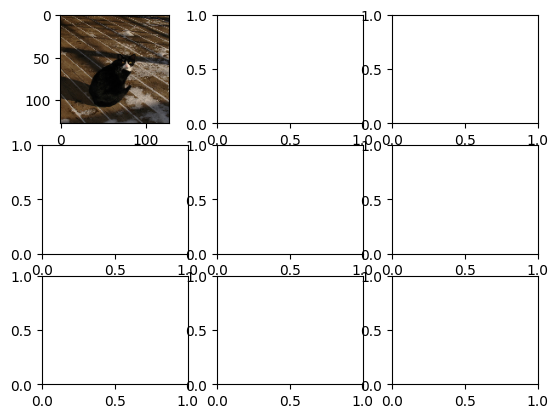

In [187]:
fig, axs = plt.subplots(nrows= 3 , ncols= 3 )
    
for i in range(3):
    x, y = test_dataset[i]

    draw_img = x.type('torch.IntTensor')
    draw_points = model.forward(torch.stack([x]))[0].detach().numpy()
    #draw_right_points = y.detach().numpy()
    axs[0, i].imshow(draw_img.permute(1,2,0))
    for i in range(0, len(draw_points),2):
                x, y = draw_points[i], draw_points[i+1] 
                #axs[0, i].plot(x,y, 'ro', color = 'red')
    #for i in range(0, len(draw_right_points),2):
                #x, y = draw_right_points[i], draw_right_points[i+1] 
                #plt.plot(x,y, 'ro', color = 'blue')
    plt.show()

In [163]:
pred = []
for x in result_dataloader_1:
    preds = model.forward(x[0])
    pred.append(preds[0].tolist())
predSizesNames = pd.read_csv('datasets/predictSizez&names.csv')

In [164]:
columns = pd.read_csv('train_labels.csv').columns
result = pd.DataFrame(columns=columns)

In [167]:
for row in range(len(pred)):
    width = predSizesNames.loc[row,'0']
    height = predSizesNames.loc[row,'0']
    for i in range(0, len(pred[row]),2):
            pred[row][i] = pred[row][i]*(width/size)
            pred[row][i+1] = pred[row][i+1]*(height/size)

In [169]:
for row in range(len(pred)):
    result.loc[-1] = pred[row]+[predSizesNames.loc[row,'2']]
    result.index = result.index + 1
    result = result.sort_index()

In [173]:
result = result.rename(columns={"file_name":"file_names"})

In [174]:
result.to_csv('results/result.csv',index=False)